# FPL Points Predictor Modeling

### Package Installments

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Creating useful functions

In [3]:
def val_curve(model, df_x, df_y):
    degree = np.arange(10)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)

    plt.plot(degree, np.median(train_score,1), color = 'blue', label = 'training curve')
    plt.plot(degree, np.median(val_score,1), color = 'red', label = 'validation curve')
    plt.legend(loc = 'best')
    plt.ylim(0,1);

In [4]:
def best_degree(model, df_x,df_y):
    degree = np.arange(10)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    degree = pd.Series(degree)
    train = pd.Series(np.max(train_score,1))
    val = pd.Series(np.max(val_score,1))
    record = pd.DataFrame({'degree': degree, 'train_score': train, 'val_score': val})
    record_max = record.loc[record[['val_score']].idxmax(), 'degree']
    record_max2 = record_max.reset_index(drop = True)
    return record_max2[0]

In [5]:
def split_data(df_new, rand_state = 69):
    df_x = df_new[['player_name','ict_index','selected_by_percent','bps', 'position_index','minutes.played']]
    df_y = df_new['total_points']
    df_xm = df_new[['ict_index','selected_by_percent','bps', 'position_index']]
    df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df_x, df_y, random_state = rand_state, train_size = 0.8)
    df_xtrain_new = df_xtrain[['ict_index','selected_by_percent','bps', 'position_index']]
    df_xtest_new = df_xtest[['ict_index','selected_by_percent','bps', 'position_index']]
    return (df_x, df_y, df_xm, df_xtrain, df_xtest, df_ytrain, df_ytest, df_xtrain_new, df_xtest_new)

In [6]:
def new_output(df_xtest,df_ytest, df_pred):
    df_m = df_xtest.copy()
    df_m['total_points'] = df_ytest
    df_m['fpl_to_game'] = (df_m['total_points']/df_m['minutes.played'])*90
    df_m['pred_points'] = df_pred
    df_m['fpl_to_game pred'] = (df_m['pred_points']/df_m['minutes.played'])*90
    df_m2 = df_m.reset_index()
    df_m2 = df_m2.drop('index', axis = 1)
    return df_m2.head()

## Premier League 2016/17

In [7]:
## Loading the datasets
import pandas as pd
s17 = pd.read_csv("~/DSI-SRP1/season2017.csv")

In [8]:
s17.head()

,Unnamed: 0,player_name,position,date_of_birth,age,nationality,club_name,league_name,season,year,...,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,position_index,fpl_to_game
0,1,Joe Hart,Goalkeeper,1987-04-19T00:00:00Z,29,England,Manchester City,Premier League,2016/2017,2016,...,0,0,0,0.0,0,0,0,1.0,1,NaN
1,2,Claudio Bravo,Goalkeeper,1983-04-13T00:00:00Z,33,Chile,Manchester City,Premier League,2016/2017,2016,...,0,3,366,28.9,6,0,0,1.2,1,3.338415
2,3,Willy Caballero,Goalkeeper,1981-09-28T00:00:00Z,34,Argentina,Manchester City,Premier League,2016/2017,2016,...,0,1,295,26.8,6,0,0,3.8,1,3.966942
3,4,Angus Gunn,Goalkeeper,1996-01-22T00:00:00Z,20,England,Manchester City,Premier League,2016/2017,2016,...,0,0,0,0.0,0,0,0,0.0,1,NaN
4,5,Nicolás Otamendi,Centre-Back,1988-02-12T00:00:00Z,28,Argentina,Manchester City,Premier League,2016/2017,2016,...,276,10,640,117.6,9,0,9,3.2,2,3.472222


In [9]:
s17 = s17.drop("Unnamed: 0", axis = 1)

In [10]:
s17.columns

Index(['player_name', 'position', 'date_of_birth', 'age', 'nationality',
       'club_name', 'league_name', 'season', 'year', 'first_name',
       'second_name', 'goals_scored', 'assists', 'total_points',
       'minutes.played', 'goals_conceded', 'creativity', 'influence', 'threat',
       'bonus', 'bps', 'ict_index', 'clean_sheets', 'red_cards',
       'yellow_cards', 'selected_by_percent', 'position_index', 'fpl_to_game'],
      dtype='object')

In [11]:
s17_new = s17[['player_name','age', 'goals_scored','assists','total_points','minutes.played','bonus','bps','goals_conceded', 'clean_sheets','ict_index','position_index','fpl_to_game','selected_by_percent']]

In [12]:
s17_new.head()

,player_name,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
0,Joe Hart,29,0,0,0,0,0,0,0,0,0.0,1,NaN,1.0
1,Claudio Bravo,33,0,0,73,1968,3,366,26,6,28.9,1,3.338415,1.2
2,Willy Caballero,34,0,0,64,1452,1,295,13,6,26.8,1,3.966942,3.8
3,Angus Gunn,20,0,0,0,0,0,0,0,0,0.0,1,NaN,0.0
4,Nicolás Otamendi,28,1,2,100,2592,10,640,28,9,117.6,2,3.472222,3.2


In [13]:
s17_new = s17_new.dropna(axis = 0)
s17_new.head()

,player_name,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
1,Claudio Bravo,33,0,0,73,1968,3,366,26,6,28.9,1,3.338415,1.2
2,Willy Caballero,34,0,0,64,1452,1,295,13,6,26.8,1,3.966942,3.8
4,Nicolás Otamendi,28,1,2,100,2592,10,640,28,9,117.6,2,3.472222,3.2
5,Vincent Kompany,30,3,0,57,820,6,227,6,5,40.6,2,6.256098,3.2
6,John Stones,22,0,0,59,2014,4,435,29,4,69.7,2,2.636544,13.3


In [14]:
s17_new.shape

(509, 14)

In [15]:
s17_new = s17_new[s17_new['minutes.played'] >= 1000]

In [16]:
s17_new.shape

(306, 14)

In [17]:
s17_new.corr()

,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
age,1.000000,-0.062001,-0.138328,0.026845,0.164490,0.008326,0.126375,0.183158,-0.035646,-0.076781,-0.223413,-0.105725,0.017608
goals_scored,-0.062001,1.000000,0.498217,0.690349,0.205668,0.737272,0.328419,0.059197,0.253961,0.792224,0.583185,0.712509,0.557945
assists,-0.138328,0.498217,1.000000,0.592955,0.185481,0.575012,0.318877,-0.005387,0.287673,0.753690,0.397088,0.624787,0.326061
total_points,0.026845,0.690349,0.592955,1.000000,0.699145,0.852295,0.835442,0.261623,0.726936,0.823468,0.105606,0.678103,0.745726
minutes.played,0.164490,0.205668,0.185481,0.699145,1.000000,0.456435,0.863463,0.698862,0.659871,0.493835,-0.265193,-0.003630,0.458215
bonus,0.008326,0.737272,0.575012,0.852295,0.456435,1.000000,0.691082,0.150742,0.496172,0.788796,0.203345,0.691338,0.684229
bps,0.126375,0.328419,0.318877,0.835442,0.863463,0.691082,1.000000,0.433339,0.751429,0.579820,-0.315527,0.313055,0.608157
goals_conceded,0.183158,0.059197,-0.005387,0.261623,0.698862,0.150742,0.433339,1.000000,0.017626,0.220955,-0.182380,-0.312214,0.083222
clean_sheets,-0.035646,0.253961,0.287673,0.726936,0.659871,0.496172,0.751429,0.017626,1.000000,0.491772,-0.119520,0.355707,0.522137
ict_index,-0.076781,0.792224,0.753690,0.823468,0.493835,0.788796,0.579820,0.220955,0.491772,1.000000,0.418957,0.619445,0.556256


In [18]:
s17_keep = s17_new[s17_new['position_index'] == 1]

In [19]:
s17_keep.corr()

,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
age,1.000000,NaN,-0.254577,-0.220816,-0.075284,-0.026263,-0.102476,0.182257,-0.296313,-0.027654,NaN,-0.266260,-0.317935
goals_scored,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
assists,-0.254577,NaN,1.000000,-0.113193,-0.287614,-0.045135,-0.191583,-0.290214,0.093360,-0.182569,NaN,0.406121,-0.189040
total_points,-0.220816,NaN,-0.113193,1.000000,0.883526,0.407129,0.918445,0.233142,0.848705,0.619399,NaN,0.493398,0.526620
minutes.played,-0.075284,NaN,-0.287614,0.883526,1.000000,0.288260,0.942035,0.578474,0.631014,0.704844,NaN,0.059974,0.385231
bonus,-0.026263,NaN,-0.045135,0.407129,0.288260,1.000000,0.483069,0.337400,0.058859,0.635918,NaN,0.320432,0.233156
bps,-0.102476,NaN,-0.191583,0.918445,0.942035,0.483069,1.000000,0.554198,0.615684,0.844588,NaN,0.229047,0.395656
goals_conceded,0.182257,NaN,-0.290214,0.233142,0.578474,0.337400,0.554198,1.000000,-0.167679,0.712398,NaN,-0.533931,-0.057794
clean_sheets,-0.296313,NaN,0.093360,0.848705,0.631014,0.058859,0.615684,-0.167679,1.000000,0.164963,NaN,0.618908,0.411143
ict_index,-0.027654,NaN,-0.182569,0.619399,0.704844,0.635918,0.844588,0.712398,0.164963,1.000000,NaN,0.018481,0.305963


In [20]:
s17_x, s17_y, s17_xm, s17_xtrain, s17_xtest, s17_ytrain, s17_ytest, s17_xtrain_new, s17_xtest_new = split_data(s17_new)

In [21]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())

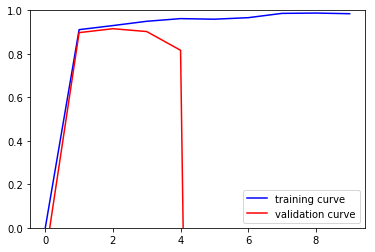

In [22]:
val_curve(model, s17_xm, s17_y)

In [23]:
model = make_pipeline(PolynomialFeatures(best_degree(model, s17_xm,s17_y)), LinearRegression())

In [24]:
s17_pred = model.fit(s17_xtrain_new,s17_ytrain).predict(s17_xtest_new)

In [25]:
r2_score(s17_pred, s17_ytest)

0.89849307872579454

In [26]:
scores17 = cross_val_score(model,s17_xm,s17_y, cv = 5)
scores17

array([ 0.80927945,  0.90250777,  0.91631688,  0.9277961 ,  0.82798556])

In [27]:
scores17.mean()

0.87677715103800991

In [28]:
new_output(s17_xtest,s17_ytest, s17_pred)

,player_name,ict_index,selected_by_percent,bps,position_index,minutes.played,total_points,fpl_to_game,pred_points,fpl_to_game pred
0,Alex Iwobi,138.7,1.1,352,4,1456,89,5.501374,90.885056,5.617895
1,Martin Olsson,52.6,0.8,234,2,1252,52,3.738019,41.004273,2.947591
2,Sergio Agüero,323.9,17.6,640,5,2404,175,6.551581,188.020168,7.039025
3,Michael Keane,158.6,3.3,619,2,3150,113,3.228571,106.450699,3.041449
4,Andy Carroll,119.2,2.0,256,5,1312,69,4.733232,79.844224,5.477119


## Premier League 2017-18

In [29]:
## Loading the datasets
s18 = pd.read_csv("~/DSI-SRP1/season2018.csv")

In [30]:
s18.head()

,Unnamed: 0,player_name,position,date_of_birth,age,nationality,club_name,league_name,season,year,...,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,position_index,fpl_to_game
0,1,Thibaut Courtois,Goalkeeper,1992-05-11T00:00:00Z,25,Belgium,Chelsea FC,Premier League,2017/2018,2017,...,4,635,55.2,15,0,2,10.3,53,1,3.885714
1,2,Willy Caballero,Goalkeeper,1981-09-28T00:00:00Z,35,Argentina,Chelsea FC,Premier League,2017/2018,2017,...,0,54,5.5,1,0,0,0.1,48,1,3.666667
2,3,Antonio Rüdiger,Centre-Back,1993-03-03T00:00:00Z,24,Germany,Chelsea FC,Premier League,2017/2018,2017,...,8,557,84.8,12,0,4,3.3,58,2,4.430651
3,4,Andreas Christensen,Centre-Back,1996-04-10T00:00:00Z,21,Denmark,Chelsea FC,Premier League,2017/2018,2017,...,4,475,64.3,8,0,0,1.9,53,2,3.439768
4,5,Gary Cahill,Centre-Back,1985-12-19T00:00:00Z,31,England,Chelsea FC,Premier League,2017/2018,2017,...,2,447,65.4,9,1,1,3.0,62,2,3.198847


In [31]:
s18 = s18.drop("Unnamed: 0", axis =1)

In [32]:
s18.head()

,player_name,position,date_of_birth,age,nationality,club_name,league_name,season,year,first_name,...,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,position_index,fpl_to_game
0,Thibaut Courtois,Goalkeeper,1992-05-11T00:00:00Z,25,Belgium,Chelsea FC,Premier League,2017/2018,2017,Thibaut,...,4,635,55.2,15,0,2,10.3,53,1,3.885714
1,Willy Caballero,Goalkeeper,1981-09-28T00:00:00Z,35,Argentina,Chelsea FC,Premier League,2017/2018,2017,Willy,...,0,54,5.5,1,0,0,0.1,48,1,3.666667
2,Antonio Rüdiger,Centre-Back,1993-03-03T00:00:00Z,24,Germany,Chelsea FC,Premier League,2017/2018,2017,Antonio,...,8,557,84.8,12,0,4,3.3,58,2,4.430651
3,Andreas Christensen,Centre-Back,1996-04-10T00:00:00Z,21,Denmark,Chelsea FC,Premier League,2017/2018,2017,Andreas,...,4,475,64.3,8,0,0,1.9,53,2,3.439768
4,Gary Cahill,Centre-Back,1985-12-19T00:00:00Z,31,England,Chelsea FC,Premier League,2017/2018,2017,Gary,...,2,447,65.4,9,1,1,3.0,62,2,3.198847


In [33]:
s18_new = s18[['player_name','age', 'goals_scored','assists','total_points','minutes.played','bonus','bps','goals_conceded', 'clean_sheets','ict_index','position_index','fpl_to_game','selected_by_percent']]


In [34]:
s18_new.shape

(580, 14)

In [35]:
s18_new = s18_new[s18_new['minutes.played'] >= 1000]

In [36]:
s18_new.shape

(309, 14)

In [37]:
s18_new.corr()

,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
age,1.000000,-0.086901,-0.174757,-0.067866,0.042953,-0.025452,0.003292,0.115250,-0.030151,-0.125779,-0.124687,-0.125859,-0.068743
goals_scored,-0.086901,1.000000,0.513812,0.677734,0.122264,0.684818,0.312122,-0.059680,0.299155,0.795575,0.618756,0.727566,0.688303
assists,-0.174757,0.513812,1.000000,0.602576,0.191436,0.466222,0.338288,-0.014537,0.360576,0.778453,0.417006,0.588003,0.436262
total_points,-0.067866,0.677734,0.602576,1.000000,0.653346,0.832302,0.836063,0.237303,0.750179,0.816782,0.170530,0.670469,0.786018
minutes.played,0.042953,0.122264,0.191436,0.653346,1.000000,0.422670,0.837399,0.745504,0.633466,0.447882,-0.196307,-0.070202,0.402830
bonus,-0.025452,0.684818,0.466222,0.832302,0.422670,1.000000,0.680570,0.122599,0.524333,0.692733,0.222152,0.674521,0.709928
bps,0.003292,0.312122,0.338288,0.836063,0.837399,0.680570,1.000000,0.443371,0.767786,0.573856,-0.237223,0.308249,0.641626
goals_conceded,0.115250,-0.059680,-0.014537,0.237303,0.745504,0.122599,0.443371,1.000000,0.039100,0.156340,-0.175749,-0.365843,0.042312
clean_sheets,-0.030151,0.299155,0.360576,0.750179,0.633466,0.524333,0.767786,0.039100,1.000000,0.543382,-0.050145,0.383811,0.574088
ict_index,-0.125779,0.795575,0.778453,0.816782,0.447882,0.692733,0.573856,0.156340,0.543382,1.000000,0.487646,0.614558,0.656844


In [38]:
s18_x, s18_y, s18_xm, s18_xtrain, s18_xtest, s18_ytrain, s18_ytest, s18_xtrain_new, s18_xtest_new = split_data(s18_new)

In [39]:
model2 = make_pipeline(PolynomialFeatures(), LinearRegression())

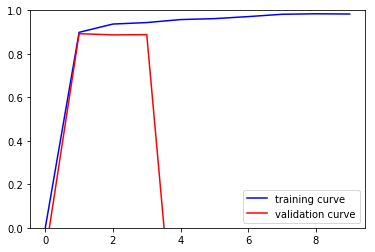

In [40]:
val_curve(model2, s18_xm, s18_y)

In [41]:
model2 = make_pipeline(PolynomialFeatures(best_degree(model2, s18_xm,s18_y)), LinearRegression())

In [42]:
s18_pred = model2.fit(s18_xtrain_new, s18_ytrain).predict(s18_xtest_new)

In [43]:
r2_score(s18_pred, s18_ytest)

0.91775956097428479

In [44]:
scores18 = cross_val_score(model2,s18_xm, s18_y, cv = 5)
scores18

array([ 0.83844963,  0.95136751,  0.88221429,  0.92766659,  0.8870888 ])

In [45]:
scores18.mean()

0.89735736578413816

In [46]:
new_output(s18_xtest, s18_ytest, s18_pred)

,player_name,ict_index,selected_by_percent,bps,position_index,minutes.played,total_points,fpl_to_game,pred_points,fpl_to_game pred
0,Gary Cahill,65.4,3.0,447,2,2082,74,3.198847,80.867014,3.495692
1,Pedro Rodríguez Ledesma,124.6,1.0,272,4,1511,81,4.824619,77.161307,4.595975
2,Chris Löwe,43.0,1.1,321,2,1585,60,3.406940,55.123934,3.130066
3,Steven Davis,82.5,1.3,337,3,1515,71,4.217822,66.782874,3.967299
4,Ruben Loftus-Cheek,124.5,3.5,337,3,1871,77,3.703902,78.621402,3.781895


## Premier League 2018/19

In [47]:
## Loading the datsets
s19 = pd.read_csv("~/DSI-SRP1/season2019.csv")

In [48]:
s19.head()

,Unnamed: 0,player_name,position,date_of_birth,age,nationality,club_name,league_name,season,year,...,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost,position_index,fpl_to_game
0,1,Ederson Santana de Moraes,Goalkeeper,1993-08-17T00:00:00Z,25,Brazil,Manchester City,Premier League,2018/2019,2018,...,6.0,700,56.8,20,0,2,22.9,57,1,4.447368
1,2,Claudio Bravo,Goalkeeper,1983-04-13T00:00:00Z,36,Chile,Manchester City,Premier League,2018/2019,2018,...,0.0,0,0.0,0,0,0,0.1,48,1,NaN
2,3,John Stones,Centre-Back,1994-05-28T00:00:00Z,25,England,Manchester City,Premier League,2018/2019,2018,...,9.0,431,54.1,9,0,1,4.6,52,2,4.241908
3,4,Aymeric Laporte,Centre-Back,1994-05-27T00:00:00Z,25,France,Manchester City,Premier League,2018/2019,2018,...,16.0,768,131.2,18,0,3,16.7,63,2,5.212696
4,5,Nicolás Otamendi,Centre-Back,1988-02-12T00:00:00Z,31,Argentina,Manchester City,Premier League,2018/2019,2018,...,5.0,335,47.8,9,0,1,2.6,60,2,5.109489


In [49]:
s19 = s19.drop('Unnamed: 0', axis =1)

In [50]:
s19_new = s19[['player_name','age', 'goals_scored','assists','total_points','minutes.played','bonus','bps','goals_conceded', 'clean_sheets','ict_index','position_index','fpl_to_game','selected_by_percent']]


In [51]:
s19_new.shape

(461, 14)

In [52]:
s19_new = s19_new[s19_new['minutes.played'] >= 1000]

In [53]:
s19_new.shape

(269, 14)

In [54]:
s19_new.corr()

,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
age,1.000000,-0.064876,-0.170670,-0.080101,-0.029226,-0.013376,0.001951,-0.006915,-0.041873,-0.133911,-0.164902,-0.087252,-0.084559
goals_scored,-0.064876,1.000000,0.596603,0.689291,0.217135,0.722603,0.327174,0.002309,0.303463,0.837944,0.668491,0.712972,0.551136
assists,-0.170670,0.596603,1.000000,0.641911,0.197061,0.611768,0.371209,-0.061416,0.360570,0.776881,0.451870,0.665973,0.567071
total_points,-0.080101,0.689291,0.641911,1.000000,0.683910,0.867632,0.839868,0.163526,0.763539,0.814954,0.218633,0.703978,0.793061
minutes.played,-0.029226,0.217135,0.197061,0.683910,1.000000,0.480045,0.856772,0.679005,0.631515,0.475816,-0.175123,0.012693,0.472002
bonus,-0.013376,0.722603,0.611768,0.867632,0.480045,1.000000,0.710354,0.098181,0.540434,0.764820,0.282279,0.697524,0.739780
bps,0.001951,0.327174,0.371209,0.839868,0.856772,0.710354,1.000000,0.359342,0.755405,0.568488,-0.198735,0.347995,0.664929
goals_conceded,-0.006915,0.002309,-0.061416,0.163526,0.679005,0.098181,0.359342,1.000000,-0.042333,0.168729,-0.167271,-0.376362,0.015922
clean_sheets,-0.041873,0.303463,0.360570,0.763539,0.631515,0.540434,0.755405,-0.042333,1.000000,0.488312,-0.021244,0.421861,0.617652
ict_index,-0.133911,0.837944,0.776881,0.814954,0.475816,0.764820,0.568488,0.168729,0.488312,1.000000,0.519880,0.645784,0.626344


In [55]:
s19_x, s19_y, s19_xm, s19_xtrain, s19_xtest, s19_ytrain, s19_ytest, s19_xtrain_new, s19_xtest_new = split_data(s19_new)

In [56]:
model3 = make_pipeline(PolynomialFeatures(), LinearRegression())

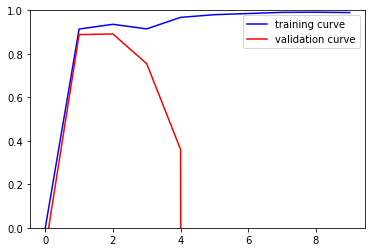

In [57]:
val_curve(model3, s19_xm, s19_y)

In [58]:
model3 = make_pipeline(PolynomialFeatures(best_degree(model3, s19_xm, s19_y)), LinearRegression())

In [59]:
model3.fit(s19_xtrain_new, s19_ytrain);

In [60]:
s19_pred = model3.predict(s19_xtest_new)

In [61]:
r2_score(s19_pred, s19_ytest)

0.9429234581673388

In [62]:
scores19 = cross_val_score(model3, s19_xm, s19_y, cv = 5)
scores19

array([ 0.90252339,  0.91315243,  0.87861001,  0.89146242,  0.84906018])

In [63]:
scores19.mean()

0.88696168407311138

In [64]:
new_output(s19_xtest, s19_ytest, s19_pred)

,player_name,ict_index,selected_by_percent,bps,position_index,minutes.played,total_points,fpl_to_game,pred_points,fpl_to_game pred
0,Vicente Guaita,44.8,2.4,378,1,1754,81,4.156214,62.151619,3.189080
1,Bruno Saltor Grau,29.8,0.3,229,2,1131,46,3.660477,37.418140,2.977571
2,Nampalys Mendy,39.5,0.9,291,3,2085,58,2.503597,50.606466,2.184452
3,DeAndre Yedlin,95.8,0.9,325,2,2472,63,2.293689,62.373171,2.270868
4,Mathew Ryan,70.9,4.9,547,1,3060,104,3.058824,98.423688,2.894814


## Combining the three seasons

In [65]:
s17.shape

(631, 28)

In [66]:
s18.shape

(580, 29)

In [67]:
s19.shape

(461, 29)

In [68]:
s17.columns

Index(['player_name', 'position', 'date_of_birth', 'age', 'nationality',
       'club_name', 'league_name', 'season', 'year', 'first_name',
       'second_name', 'goals_scored', 'assists', 'total_points',
       'minutes.played', 'goals_conceded', 'creativity', 'influence', 'threat',
       'bonus', 'bps', 'ict_index', 'clean_sheets', 'red_cards',
       'yellow_cards', 'selected_by_percent', 'position_index', 'fpl_to_game'],
      dtype='object')

In [69]:
s18.columns

Index(['player_name', 'position', 'date_of_birth', 'age', 'nationality',
       'club_name', 'league_name', 'season', 'year', 'first_name',
       'second_name', 'goals_scored', 'assists', 'total_points',
       'minutes.played', 'goals_conceded', 'creativity', 'influence', 'threat',
       'bonus', 'bps', 'ict_index', 'clean_sheets', 'red_cards',
       'yellow_cards', 'selected_by_percent', 'now_cost', 'position_index',
       'fpl_to_game'],
      dtype='object')

In [70]:
s17_c = s17.copy()
s18_c = s18.drop('now_cost', axis = 1).copy()
s19_c = s19.drop('now_cost', axis = 1).copy()

In [71]:
seasons = pd.concat([s17_c,s18_c,s19_c], axis = 0)

In [72]:
seasons.shape

(1672, 28)

In [73]:
seasons.head()

,player_name,position,date_of_birth,age,nationality,club_name,league_name,season,year,first_name,...,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,position_index,fpl_to_game
0,Joe Hart,Goalkeeper,1987-04-19T00:00:00Z,29,England,Manchester City,Premier League,2016/2017,2016,Joe,...,0,0.0,0,0.0,0,0,0,1.0,1,NaN
1,Claudio Bravo,Goalkeeper,1983-04-13T00:00:00Z,33,Chile,Manchester City,Premier League,2016/2017,2016,Claudio,...,0,3.0,366,28.9,6,0,0,1.2,1,3.338415
2,Willy Caballero,Goalkeeper,1981-09-28T00:00:00Z,34,Argentina,Manchester City,Premier League,2016/2017,2016,Willy,...,0,1.0,295,26.8,6,0,0,3.8,1,3.966942
3,Angus Gunn,Goalkeeper,1996-01-22T00:00:00Z,20,England,Manchester City,Premier League,2016/2017,2016,Angus,...,0,0.0,0,0.0,0,0,0,0.0,1,NaN
4,Nicolás Otamendi,Centre-Back,1988-02-12T00:00:00Z,28,Argentina,Manchester City,Premier League,2016/2017,2016,Nicolás,...,276,10.0,640,117.6,9,0,9,3.2,2,3.472222


In [74]:
seasons = seasons[seasons['minutes.played'] >= 1000]
seasons.shape

(884, 28)

In [75]:
seasons_new = seasons[['player_name','age', 'goals_scored','assists','total_points','minutes.played','bonus','bps','goals_conceded', 'clean_sheets','ict_index','position_index','fpl_to_game','selected_by_percent']]


In [76]:
seasons_new.corr()

,age,goals_scored,assists,total_points,minutes.played,bonus,bps,goals_conceded,clean_sheets,ict_index,position_index,fpl_to_game,selected_by_percent
age,1.000000,-0.067953,-0.159127,-0.035068,0.070383,-0.007445,0.046818,0.108092,-0.036911,-0.107661,-0.174640,-0.108476,-0.041960
goals_scored,-0.067953,1.000000,0.534600,0.685531,0.182234,0.714781,0.322073,0.003868,0.285441,0.807876,0.619874,0.716571,0.597053
assists,-0.159127,0.534600,1.000000,0.611509,0.190967,0.550504,0.341650,-0.026453,0.336028,0.769264,0.420101,0.624004,0.445923
total_points,-0.035068,0.685531,0.611509,1.000000,0.679002,0.850913,0.835794,0.219947,0.746538,0.817869,0.161995,0.682704,0.774669
minutes.played,0.070383,0.182234,0.190967,0.679002,1.000000,0.453426,0.851663,0.706341,0.638182,0.473240,-0.215164,-0.022252,0.443955
bonus,-0.007445,0.714781,0.550504,0.850913,0.453426,1.000000,0.693606,0.124943,0.519416,0.749660,0.233021,0.685851,0.710101
bps,0.046818,0.322073,0.341650,0.835794,0.851663,0.693606,1.000000,0.410067,0.755726,0.573971,-0.251996,0.321609,0.635613
goals_conceded,0.108092,0.003868,-0.026453,0.219947,0.706341,0.124943,0.410067,1.000000,0.000266,0.183861,-0.176094,-0.351936,0.047165
clean_sheets,-0.036911,0.285441,0.336028,0.746538,0.638182,0.519416,0.755726,0.000266,1.000000,0.506029,-0.062569,0.388548,0.574506
ict_index,-0.107661,0.807876,0.769264,0.817869,0.473240,0.749660,0.573971,0.183861,0.506029,1.000000,0.472248,0.624643,0.611718


In [77]:
seasons_x, seasons_y, seasons_xm, seasons_xtrain, seasons_xtest, seasons_ytrain, seasons_ytest, seasons_xtrain_new, seasons_xtest_new = split_data(seasons_new, 7)


In [78]:
model_s = make_pipeline(PolynomialFeatures(), LinearRegression())

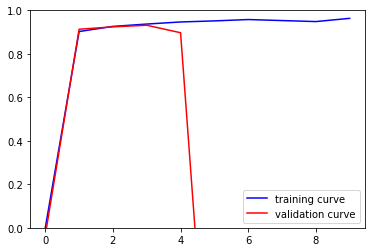

In [79]:
val_curve(model_s, seasons_xm, seasons_y)

In [80]:
model_s = make_pipeline(PolynomialFeatures(best_degree(model_s,seasons_xm,seasons_y)), LinearRegression())

In [81]:
seasons_pred = model_s.fit(seasons_xtrain_new, seasons_ytrain).predict(seasons_xtest_new)

In [82]:
r2_score(seasons_pred, seasons_ytest)

0.93678448778216994

In [83]:
scores = cross_val_score(model_s, seasons_xm, seasons_y, cv = 5)
scores

array([ 0.93154658,  0.90535627,  0.94485905,  0.94372815,  0.89973956])

In [84]:
scores.mean()

0.92504592136120389

In [85]:
new_output(seasons_xtest, seasons_ytest, seasons_pred)

,player_name,ict_index,selected_by_percent,bps,position_index,minutes.played,total_points,fpl_to_game,pred_points,fpl_to_game pred
0,Sofiane Boufal,78.6,0.1,160,3,1104,40,3.260870,44.459765,3.624437
1,Dan Gosling,78.1,0.1,237,3,1734,54,2.802768,53.300659,2.766470
2,Ashley Barnes,125.5,4.3,241,5,1774,81,4.109357,82.521251,4.186535
3,Alex Iwobi,138.7,1.1,352,4,1456,89,5.501374,92.266246,5.703271
4,Darren Randolph,48.7,1.3,370,1,1980,69,3.136364,67.771624,3.080528
